# RELATION OF THE XCT COMPUTED TOMOGRAPHY WITH THE ULTRASOUND PULSE ECHO
## **Estimate XCT features with several models and ultrasonic derived features**
### Part 4/X 

### **GOAL**
1. Compare different models to predict the void volume fraction.
    * Use of lineal regression, regression tree and random forest algorithms to estimate with windows = 3x3,5x5 mm^2
2. Compare different models to predict the number of voids.
    * Use of lineal regression, regression tree and random forest algorithms to estimate with window = 3x3,5x5 mm^2

## **MATERIALS AND DATA**
There are two origins: data from the reconstructed XCT volume and the features of the ultrasound volume.
* Ultrasounds data: The attenuation C-scan measured in pulse-eco. 
XCT Scan
* XCT porosity projection with sime equal as the ultrasound.

*Note: Window sizes of 3x3 and 5x5 due to previous experiments*

## LIBRARIES

In [2]:
# Mathematical
import scipy
import skimage
import numpy as np
import pandas as pd

import sklearn as skl
import sklearn.metrics
import sklearn.linear_model
import sklearn.tree
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.preprocessing
from sklearn.utils import shuffle

# Operational
# import importlib
from pathlib import Path
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import napari
from napari.utils import nbscreenshot
%gui qt5

In [3]:
path_to_dfs_c4567 = Path(r"D:\OneDrive - Universidad Politécnica de Madrid\2_Tareas\20201210_Models_c24567\filter_dataframes")

df_c4_w3 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon4_w3.csv')
df_c5_w3 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon5_w3.csv')
df_c6_w3 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon6_w3.csv')
df_c7_w3 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon7_w3.csv')

df_c4_w5 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon4_w5.csv')
df_c5_w5 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon5_w5.csv')
df_c6_w5 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon6_w5.csv')
df_c7_w5 =  pd.read_csv(path_to_dfs_c4567 / 'df_fil13coupon7_w5.csv')


### Displaying images 

In [4]:
## Visualization tool

# Image sizes
c4_shape = (154,37)
c5_shape = (154,38)
c6_shape = (151,37)
c7_shape = (151,39)


## VISUALIZATION
def plot_feat_maps(feat_maps):
    viewer = napari.Viewer()
    
    for tupla in feat_maps:
        viewer.add_image(tupla[1],name=tupla[0])
    return viewer

feat_maps = [] 
for column in df_c7_w3.iloc[:,2:]:
    feat_maps.append( (column, df_c7_w3[column].to_numpy().reshape(c7_shape)) )
    
viewer = plot_feat_maps(feat_maps)

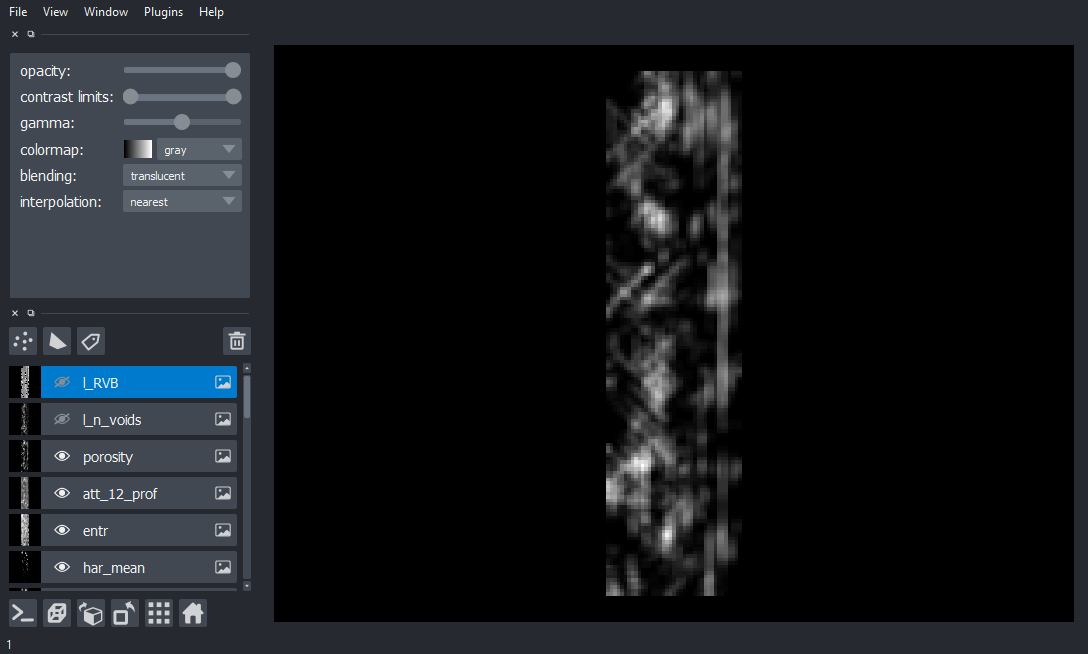

In [5]:
## Coupon 7
nbscreenshot(viewer)

## Goal 1: Estimate the void volume fraction with random forest, lineal,multilineal and regression tree models.
### *Training in c5,c6,c7; evaluation in c4*

### Dataset formation

In [46]:
l_df_c4 = [df_c4_w3,df_c4_w5]
l_df_c5 = [df_c5_w3,df_c5_w5]
l_df_c6 = [df_c6_w3,df_c6_w5]
l_df_c7 = [df_c7_w3,df_c7_w5]

l_df_error = []
ut_vol_shape = c5_shape

i=0
df_c567 = pd.concat([l_df_c5[0],l_df_c6[i],l_df_c7[i]],ignore_index=True)

df_train = shuffle(df_c567.copy())
df_test = l_df_c4[i]

In [47]:
df_train.head()

,ID,coords,att_12,att_12_m_I,att_12_g_C,sect1,sect2,sect3,sect4,maximo,...,var,skew,kurt,geo_mean,har_mean,entr,att_12_prof,porosity,l_n_voids,l_RVB
11265,5413,"['146', '149', '11', '14']",11.237294,0.193630,0.560831,7.098661,18.802217,23.588806,20.858178,82.111111,...,6.485556,0.175828,-0.799917,3.978315,2.883185,3.086502,11.424587,0.477649,11,0.645383
13956,2517,"['64', '67', '21', '24']",8.027167,0.195790,0.633017,7.561297,18.363475,16.065674,16.073368,53.444444,...,4.825556,0.391648,-0.956724,1.300801,0.246883,2.943739,8.038940,0.332202,3,0.607091
101,101,"['2', '5', '25', '28']",12.129000,0.149558,0.671192,11.449411,18.338965,18.833977,14.567597,67.777778,...,5.495926,0.801628,-0.063412,1.555113,0.274065,2.950742,11.541447,0.324485,4,0.589030
9724,3872,"['104', '107', '24', '27']",15.084453,0.332690,0.502811,10.517261,14.562509,17.305060,2.637450,76.555556,...,29.894074,1.068276,-0.097784,1.944688,0.333665,2.812308,15.445804,0.455427,8,0.696955
2782,2782,"['73', '76', '8', '11']",13.656967,0.196045,0.666611,7.843580,17.284063,19.023266,4.278198,70.000000,...,8.832963,0.634024,-0.219073,1.709133,0.288047,2.958010,13.499231,0.264970,7,0.585773


In [48]:
## Checking correlation with the void volume fraction
np.abs(df_train.corr()['porosity']).sort_values(ascending=False).head(10)

porosity         1.000000
l_n_voids        0.723638
maximo_2         0.715235
att_12_prof      0.705320
att_12           0.695894
area2            0.656322
area3            0.503002
maximo_3         0.474169
middle_maximo    0.411914
mean             0.347850
Name: porosity, dtype: float64

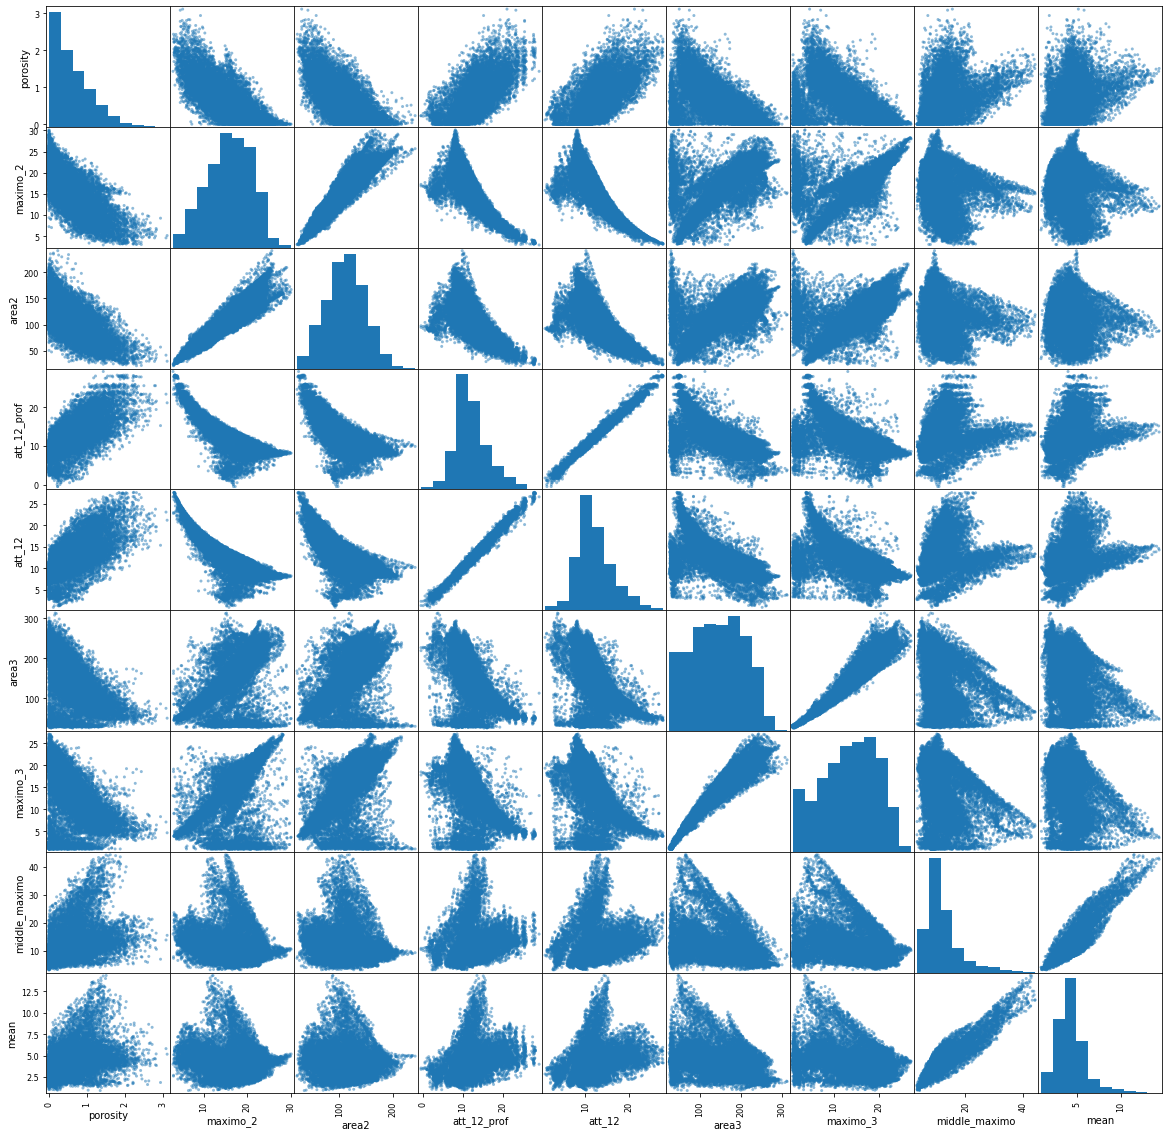

In [56]:
pd.plotting.scatter_matrix(df_train[['porosity','maximo_2', 'area2', 'att_12_prof', 'att_12','area3', 'maximo_3', 'middle_maximo', 'mean']],
                           figsize=(20,20))
plt.show()

Test scores on Random forest of each fold (5) [0.68258402 0.70671338 0.70646961 0.68409494 0.69692762] 



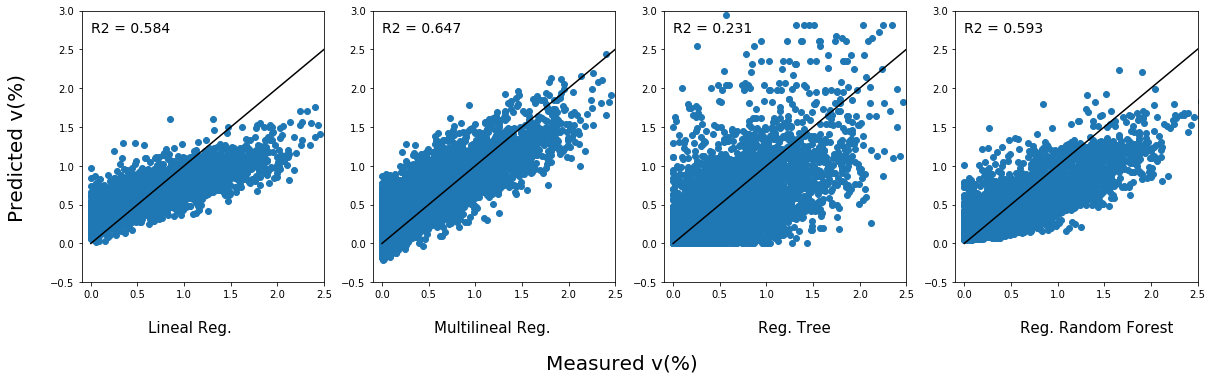

Test scores on Random forest of each fold (5) [0.8041893  0.8106046  0.80800003 0.80438567 0.80637043] 



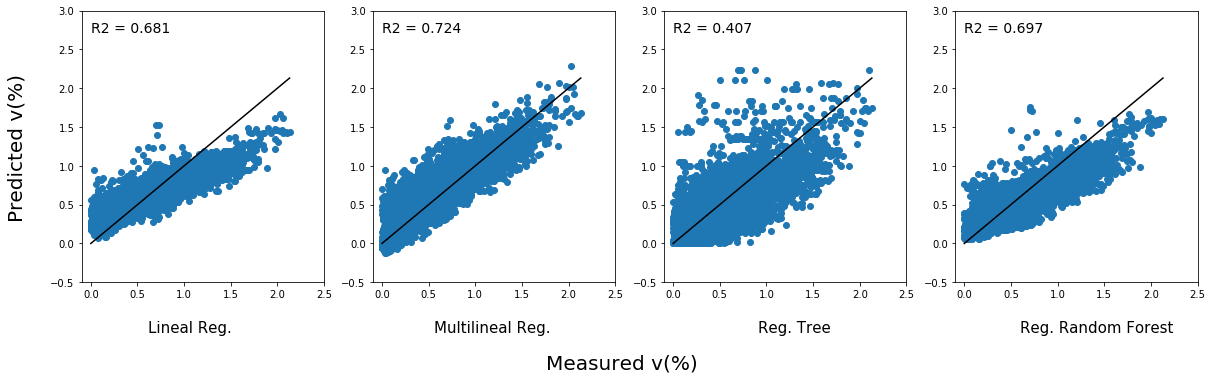

In [49]:
l_df_c4 = [df_c4_w3,df_c4_w5]
l_df_c5 = [df_c5_w3,df_c5_w5]
l_df_c6 = [df_c6_w3,df_c6_w5]
l_df_c7 = [df_c7_w3,df_c7_w5]

l_df_error = []
ut_vol_shape = c4_shape

l_df_error = []
viewers = []

#text params
init1=0
init2=2.75
spacing=0.035

for i,df in enumerate(l_df_c5):
    ## Datasets
    df_c567 = pd.concat([df,l_df_c6[i],l_df_c7[i]],ignore_index=True)

    df_train = shuffle(df_c567.copy())
    df_test = l_df_c4[i].copy()
    
    y_train = df_train['porosity'] # 'maximo_2', 'area2', 'att_12_prof', 'att_12','area3', 'maximo_3', 'middle_maximo', 'mean'
    X_train = df_train[['maximo_2', 'att_12_prof', 'att_12','maximo_3','middle_maximo']]
    # Multilineal regression needs of normalization
    X_train_sc = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_train),
                          columns=X_train.columns)
    
    X_test = df_test[['maximo_2', 'att_12_prof', 'att_12','maximo_3','middle_maximo']]
    X_test_sc = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_test),
                          columns=X_test.columns)
    y_test = df_test['porosity']
    
    ## Models
    # Linear only attenuation
    linr_att = skl.linear_model.LinearRegression()
    linr_scores_att = skl.model_selection.cross_validate(linr_att,
                                                         X_train['att_12_prof'].to_numpy().reshape((-1,1)),
                                                         y_train,
                                                         cv=5,
                                                         return_estimator=True)
 
    # MultiLineal
    linr = skl.linear_model.LinearRegression()
    linr_scores = skl.model_selection.cross_validate(linr,X_train_sc, y_train, cv=5, return_estimator=True)
#     print('Test scores on lineal of each fold (5)',linr_scores['test_score'])

    # Tree
    tree = sklearn.tree.DecisionTreeRegressor(criterion='mse')
    tree_scores = skl.model_selection.cross_validate(tree,X_train, y_train, cv=5, return_estimator=True)
#     print('Test scores on tree of each fold (5)',tree_scores['test_score'])

    # Random Forest
    n_estimators = 65
    max_feat = 0.6
    max_depth = 9
    max_samples = 0.8
    rf = skl.ensemble.RandomForestRegressor(n_estimators,
                                            max_features=max_feat,
                                            max_depth=max_depth,
                                            max_samples=max_samples )
    rf_scores  = skl.model_selection.cross_validate(rf,X_train, y_train, cv=5, return_estimator=True)
    print('Test scores on Random forest of each fold (5)',rf_scores['test_score'],'\n')
    
    
    ## Predicting
    # random estimators from one of the folds used to predict, 1st fold selected: fold=0
    lineal_rand_est = linr_scores_att['estimator'][0]
    multilin_rand_est = linr_scores['estimator'][0]
    tree_rand_est = tree_scores['estimator'][0]
    rf_rand_est = rf_scores['estimator'][0]
    
    # Lineal only att.
    linr_att_porosity = lineal_rand_est.predict(X_test['att_12_prof'].to_numpy().reshape((-1,1)))
    linr_r2_att_porosity = skl.metrics.r2_score(y_test, linr_att_porosity)                                                     
    
    # MultiLineal
    multilinr_porosity = multilin_rand_est.predict(X_test_sc)
    multilinr_r2_porosity = skl.metrics.r2_score(y_test, multilinr_porosity)

    # Tree
    tree_porosity = tree_rand_est.predict(X_test)
    tree_r2_porosity = skl.metrics.r2_score(y_test, tree_porosity)

    # Random forest
    rf_porosity = rf_rand_est.predict(X_test)
    rf_r2_porosity = skl.metrics.r2_score(y_test, rf_porosity)
    l_R2 = [linr_r2_att_porosity,
            multilinr_r2_porosity,
            tree_r2_porosity,
            rf_r2_porosity]
                  
        
    ## ERROR ANALYSIS
    df_error = pd.DataFrame(X_test)
    df_error['porosity'] = y_test

    # Saving porosity predictions
    df_error['att_lineal_porosity'] = linr_att_porosity
    df_error['multilineal_porosity'] = multilinr_porosity
    df_error['tree_porosity'] = tree_porosity
    df_error['rf_porosity'] = rf_porosity

    # Computing error as a difference of "y" and pred_y and absolute error
    df_error['att_lineal_error'] = df_error['porosity'] - df_error['att_lineal_porosity']
    df_error['multilineal_error'] = df_error['porosity'] - df_error['multilineal_porosity']
    df_error['tree_error'] = df_error['porosity'] - df_error['tree_porosity']
    df_error['rf_error'] = df_error['porosity'] - df_error['rf_porosity']

    df_error['abs_lineal_error'] = np.abs(df_error['porosity'] - df_error['att_lineal_porosity'])
    df_error['abs_multilineal_error'] = np.abs(df_error['porosity'] - df_error['multilineal_porosity'])
    df_error['abs_tree_error'] = np.abs(df_error['porosity'] - df_error['tree_porosity'])
    df_error['abs_rf_error'] = np.abs(df_error['porosity'] - df_error['rf_porosity'])

    l_df_error.append(df_error)
    
    
    ## VISUALIZATION
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    
    # Lineal fit
    ax[0].scatter(y_test,linr_att_porosity)
    ax[1].scatter(y_test,multilinr_porosity)
    ax[2].scatter(y_test,tree_porosity)
    ax[3].scatter(y_test,rf_porosity)
    
    
    for i,eje in enumerate(ax):
        eje.plot([0,np.max(y_test)],[0,np.max(y_test)],'black')  
        eje.text(init1, init2-spacing,'R2 = {}'.format(np.round(l_R2[i], decimals=3))).set_fontsize(14)
        eje.set_xlim(xmin=-0.10, xmax=2.5)
        eje.set_ylim(ymin=-0.50, ymax=3)
    
    ## Texts
    # Axis titles
    fig.text(0.5, -0.10, 'Measured v(%)', ha='center', va='center').set_fontsize(20)
    fig.text(0.08, 0.5, 'Predicted v(%)', ha='center', va='center', rotation='vertical').set_fontsize(20)

#     fig.text(0.10, 0.82, 'Window 1', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.66, 'Window 3', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.50, 'Window 5', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.35, 'Window 7', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.19, 'Window 9', ha='center', va='center', rotation='vertical').set_fontsize(15)

    fig.text(0.20, 0, 'Lineal Reg.', ha='center', va='center').set_fontsize(15)
    fig.text(0.41, 0, 'Multilineal Reg.', ha='center', va='center').set_fontsize(15)
    fig.text(0.62, 0, 'Reg. Tree', ha='center', va='center').set_fontsize(15)
    fig.text(0.83, 0, 'Reg. Random Forest', ha='center', va='center').set_fontsize(15)
    plt.show()

l_feat_maps = []    
for df_vis in l_df_error:
    feat_maps = [] 
    for column in df_vis.iloc[:,:]:
        feat_maps.append( (column, df_vis[column].to_numpy().reshape(ut_vol_shape)) )
    l_feat_maps.append(feat_maps)
    viewers.append(plot_feat_maps(feat_maps))

### *R2 Training* 

In [50]:
linr_scores['test_score']
tree_scores['test_score']
rf_scores['test_score']
df_R2_folds = pd.DataFrame({
            'Folds':list(range(1,6)),
            'Lineal Reg.': linr_scores_att['test_score'],
            'Multilineal Reg': linr_scores['test_score'],
            'Tree': tree_scores['test_score'],
            'Random Forest': rf_scores['test_score']}).set_index('Folds')

df_R2_folds.round(decimals=2)#.to_csv('training_R2_folds.csv')

,Lineal Reg.,Multilineal Reg,Tree,Random Forest
Folds,,,,
1,0.56,0.70,0.66,0.80
2,0.60,0.72,0.66,0.81
3,0.57,0.70,0.65,0.81
4,0.56,0.69,0.64,0.80
5,0.59,0.72,0.65,0.81


### Attributes coefficients

### *Lineal*

In [51]:
print('Coeficient: ',np.round(lineal_rand_est.coef_[0],decimals=3), '\n','Intercept: ',np.round(lineal_rand_est.intercept_,decimals=3))

Coeficient:  0.075 
 Intercept:  -0.399


### *MultiLineal*

In [52]:
multilin_rand_est.intercept_

0.6392074466317199

In [53]:
abs_linr_coefs = abs(multilin_rand_est.coef_)
linr_feats = X_train.columns
a_feat_imp = np.array([[feat,np.round(importance,decimals=3)] for importance, feat in sorted(zip(abs_linr_coefs,linr_feats) ,reverse=True)])
df_multilinr_feat_impor = pd.DataFrame({
            'feats (ordered)': a_feat_imp[:,0],
            'Multilineal Coefficients': a_feat_imp[:,1]}).set_index('feats (ordered)')
df_multilinr_feat_impor

,Multilineal Coefficients
feats (ordered),
att_12_prof,0.289
maximo_2,0.216
att_12,0.206
middle_maximo,0.099
maximo_3,0.05


### *Random Forest*

In [54]:
abs_rf_importances = rf_rand_est.feature_importances_


rf_feats = X_train.columns
a_feat_imp = np.array([[feat,np.round(importance,decimals=3)] for importance, feat in sorted(zip(abs_rf_importances,rf_feats) ,reverse=True)])
df_rf_feat_impor = pd.DataFrame({
            'feats (ordered)': a_feat_imp[:,0],
            'RF Coefficients': a_feat_imp[:,1]}).set_index('feats (ordered)')


In [14]:
pd.concat([df_multilinr_feat_impor,df_rf_feat_impor],axis=1)#.to_csv('c4_eval_coefficients.csv')

### Error statistics

### *Window 3*

In [55]:
l_df_error[0].iloc[:,10:].describe().round(decimals=2)#.to_csv('c4_w3_error_statistics.csv')

### *Window 5*

In [57]:
l_df_error[1].iloc[:,10:].describe().round(decimals=2)#.to_csv('c4_w5_error_statistics.csv')

,att_lineal_error,multilineal_error,tree_error,rf_error,abs_lineal_error,abs_multilineal_error,abs_tree_error,abs_rf_error
count,5698.00,5698.00,5698.00,5698.00,5698.00,5698.00,5698.00,5698.00
mean,-0.02,-0.07,0.07,0.07,0.17,0.15,0.22,0.16
std,0.21,0.19,0.28,0.20,0.13,0.13,0.19,0.13
min,-0.92,-0.92,-1.64,-1.06,0.00,0.00,0.00,0.00
25%,-0.17,-0.18,-0.08,-0.05,0.07,0.05,0.08,0.06
50%,-0.05,-0.05,0.08,0.06,0.14,0.12,0.18,0.13
75%,0.10,0.05,0.24,0.19,0.24,0.21,0.31,0.22
max,0.91,0.62,0.98,0.90,0.92,0.92,1.64,1.06


### Error as feature maps

In [17]:
### Saving error Images
def save_imagen(array, pathlibpath,tipo,norm=False):
    if (norm == True):
        array = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(array))
        imagen = Image.fromarray(array)
    else:
        imagen = Image.fromarray(array.astype(tipo))
    imagen.save(pathlibpath) 

def save_feat_maps(feat_maps,pathlibpath,tipo='float'):
    for tupla in feat_maps:
        ruta = pathlibpath / (tupla[0]+'.tif')
        save_imagen(tupla[1],ruta,tipo)
    print('All feature maps saved')

In [20]:
## Concatenation of the error imgs for the dif. error
pad = -10* np.ones((c4_shape[0],5),dtype=int)
dif_err_concat = np.concatenate([viewers[0].layers['att_lineal_error'].data,
                            pad,     
                            viewers[0].layers['multilineal_error'].data,
                            pad,     
                            viewers[0].layers['tree_error'].data,
                            pad,     
                            viewers[0].layers['rf_error'].data],axis=1)

l_feat_maps[0].append( ('dif_err_concat',dif_err_concat) )
viewers[0].add_image(dif_err_concat,
                     contrast_limits=(l_df_error[1].iloc[:,10:].min().min(),l_df_error[1].iloc[:,10:].max().max()))

## Concat. of the abs. error imgs
pad = -10* np.ones((c4_shape[0],5),dtype=int)
abs_err_concat = np.concatenate([viewers[0].layers['abs_lineal_error'].data,
                            pad,     
                            viewers[0].layers['abs_multilineal_error'].data,
                            pad,     
                            viewers[0].layers['abs_tree_error'].data,
                            pad,     
                            viewers[0].layers['abs_rf_error'].data],axis=1)

l_feat_maps[0].append( ('abs_err_concat',abs_err_concat) )
viewers[0].add_image(abs_err_concat,
                     contrast_limits=(0,l_df_error[1].iloc[:,10:].max().max()))

<Image layer 'abs_err_concat [1]' at 0x19b38b578c8>

In [21]:
## Concatenation of the error imgs for the dif. error
ii = 1
pad = -10* np.ones((c5_shape[0],5),dtype=int)
dif_err_concat = np.concatenate([viewers[ii].layers['att_lineal_error'].data,
                            pad,     
                            viewers[ii].layers['multilineal_error'].data,
                            pad,     
                            viewers[ii].layers['tree_error'].data,
                            pad,     
                            viewers[ii].layers['rf_error'].data],axis=1)

l_feat_maps[ii].append( ('dif_err_concat',dif_err_concat) )
viewers[ii].add_image(dif_err_concat,
                     contrast_limits=(l_df_error[1].iloc[:,10:].min().min(),l_df_error[1].iloc[:,10:].max().max()))

## Concat. of the abs. error imgs
pad = -10* np.ones((c5_shape[0],5),dtype=int)
abs_err_concat = np.concatenate([viewers[ii].layers['abs_lineal_error'].data,
                            pad,     
                            viewers[ii].layers['abs_multilineal_error'].data,
                            pad,     
                            viewers[ii].layers['abs_tree_error'].data,
                            pad,     
                            viewers[ii].layers['abs_rf_error'].data],axis=1)

l_feat_maps[ii].append( ('abs_err_concat',abs_err_concat) )
viewers[ii].add_image(abs_err_concat,
                     contrast_limits=(0,l_df_error[1].iloc[:,10:].max().max()))

<Image layer 'abs_err_concat' at 0x19b38d9fe48>

In [23]:
save_feat_maps(l_feat_maps[1],Path().cwd())

All feature maps saved


### *Training in c4,c6,c7; evaluation in c5*

### Dataset formation

In [58]:
l_df_c4 = [df_c4_w3,df_c4_w5]
l_df_c5 = [df_c5_w3,df_c5_w5]
l_df_c6 = [df_c6_w3,df_c6_w5]
l_df_c7 = [df_c7_w3,df_c7_w5]

l_df_error = []
ut_vol_shape = c5_shape

i=0
df_c467 = pd.concat([l_df_c4[i],l_df_c6[i],l_df_c7[i]],ignore_index=True)

df_train = shuffle(df_c467.copy())
df_test = l_df_c5[i]

In [59]:
df_train.head()

,ID,coords,att_12,att_12_m_I,att_12_g_C,sect1,sect2,sect3,sect4,maximo,...,var,skew,kurt,geo_mean,har_mean,entr,att_12_prof,porosity,l_n_voids,l_RVB
6091,393,"['10', '13', '23', '26']",9.864105,0.268458,0.530335,11.680283,17.448436,19.351820,21.282348,65.333333,...,7.512963,-0.041610,-1.181523,1.992007,0.001735,3.000857,9.943763,0.246400,6,0.697290
16665,5380,"['137', '140', '37', '40']",5.755477,0.243324,0.557921,9.042875,6.574254,6.812025,7.846139,28.000000,...,15.482593,1.917049,3.148144,0.288007,0.000427,2.506220,4.680175,0.420566,3,0.637765
10807,5109,"['138', '141', '3', '6']",11.370703,0.356244,0.509701,10.952313,16.394176,20.555604,20.515890,73.111111,...,14.290741,0.714948,-0.138224,2.504343,0.002221,2.954375,11.360821,0.501393,4,0.552496
965,965,"['26', '29', '3', '6']",11.715706,0.260214,0.510653,8.838301,20.088242,0.000000,15.958424,77.444444,...,6.024074,-0.008770,-1.101723,1.495699,0.001296,2.987333,11.614106,0.328813,7,0.567006
9057,3359,"['90', '93', '29', '32']",19.909534,0.307821,0.555970,11.073326,12.812475,15.809331,0.000000,71.111111,...,18.136667,1.006288,0.839674,2.756144,0.329357,2.935161,19.991318,0.737264,12,0.621102


In [60]:
df_train.columns

Index(['ID', 'coords', 'att_12', 'att_12_m_I', 'att_12_g_C', 'sect1', 'sect2',
       'sect3', 'sect4', 'maximo', 'maximo_2', 'maximo_3', 'ratio32', 'area1',
       'area12', 'area2', 'area3', 'kurt_1', 'kurt_2', 'middle_maximo', 'mean',
       'var', 'skew', 'kurt', 'geo_mean', 'har_mean', 'entr', 'att_12_prof',
       'porosity', 'l_n_voids', 'l_RVB'],
      dtype='object')

In [61]:
## Checking correlation with the void volume fraction
np.abs(df_train.corr()['porosity']).sort_values(ascending=False).head(10)

porosity         1.000000
l_n_voids        0.732504
maximo_2         0.725511
att_12_prof      0.718855
att_12           0.708273
area2            0.661231
area3            0.515328
maximo_3         0.493678
middle_maximo    0.396893
mean             0.345329
Name: porosity, dtype: float64

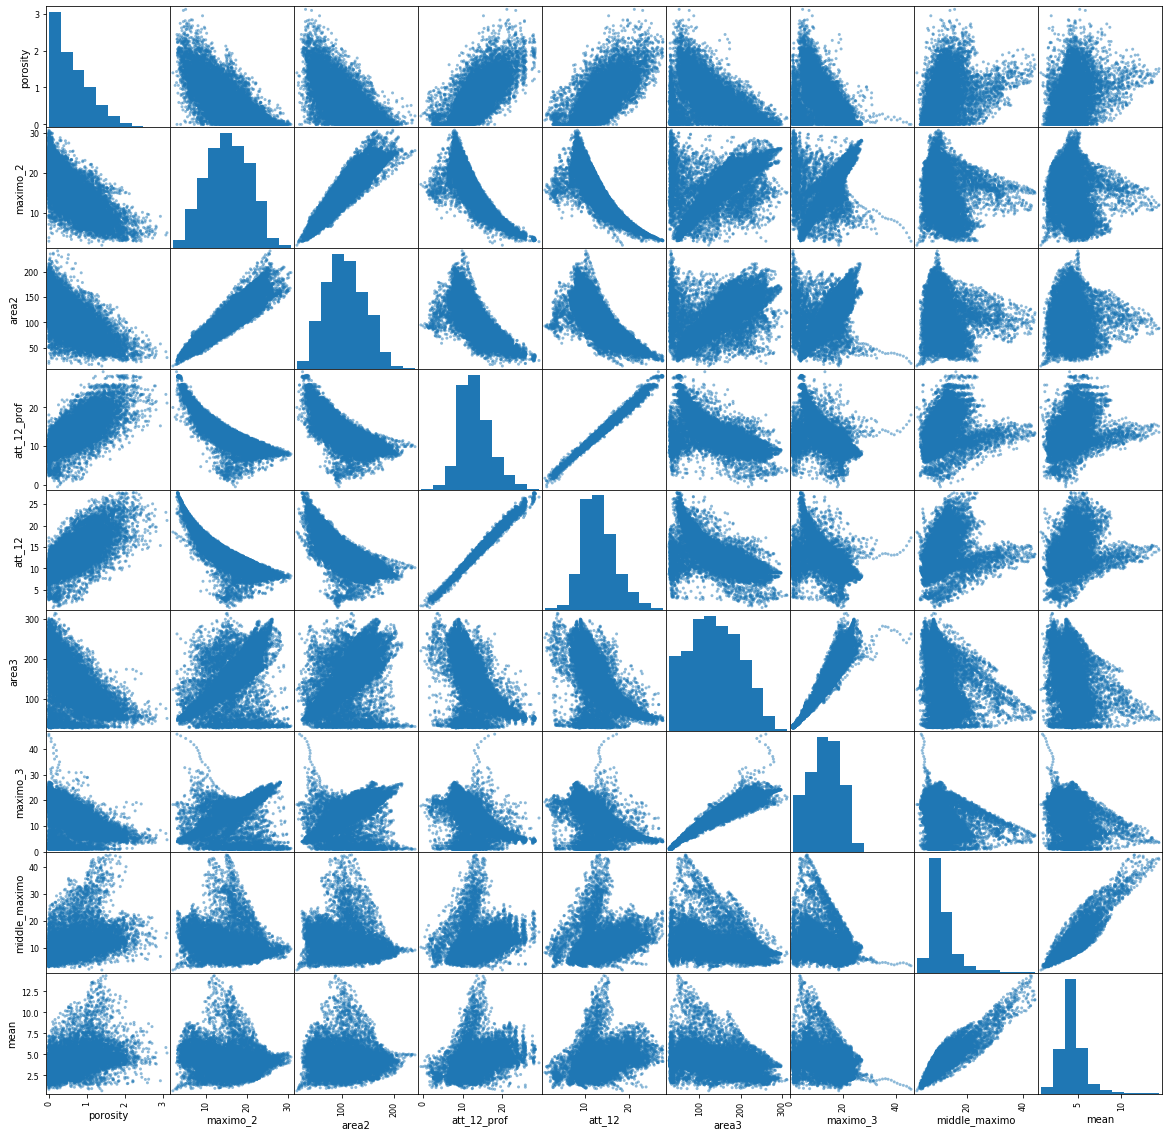

In [62]:
pd.plotting.scatter_matrix(df_train[['porosity','maximo_2', 'area2', 'att_12_prof', 'att_12','area3', 'maximo_3', 'middle_maximo', 'mean']],
                           figsize=(20,20))
plt.show()

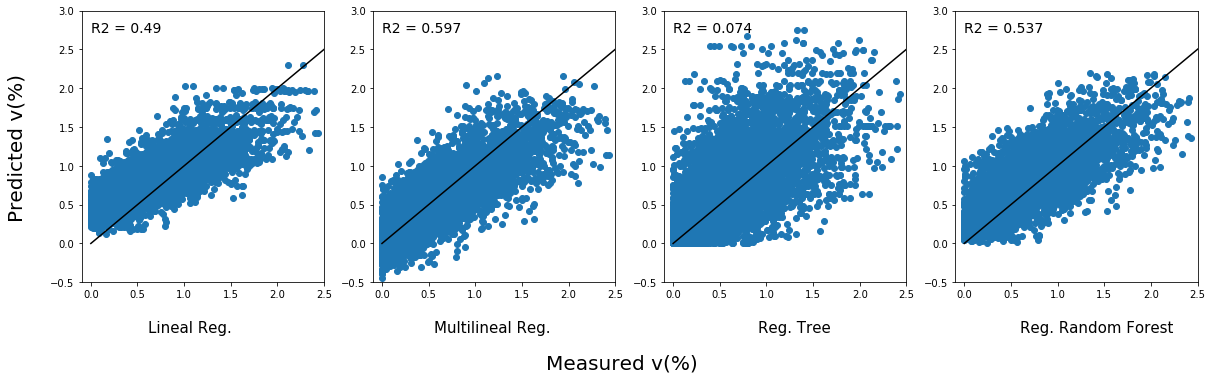

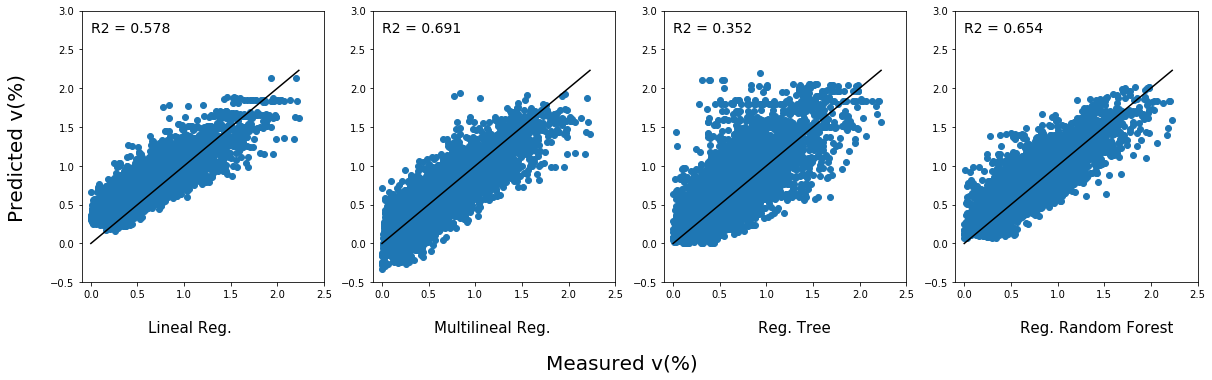

In [70]:
l_df_c4 = [df_c4_w3,df_c4_w5]
l_df_c5 = [df_c5_w3,df_c5_w5]
l_df_c6 = [df_c6_w3,df_c6_w5]
l_df_c7 = [df_c7_w3,df_c7_w5]

l_df_error = []
ut_vol_shape = c5_shape

l_df_error = []
viewers = []

#text params
init1=0
init2=2.75
spacing=0.035

for i,df in enumerate(l_df_c4):
    ## Datasets
    df_c467 = pd.concat([df,l_df_c6[i],l_df_c7[i]],ignore_index=True)

    df_train = shuffle(df_c467.copy())
    df_test = l_df_c5[i].copy()
    
    y_train = df_train['porosity'] # 'maximo_2', 'area2', 'att_12_prof', 'att_12','area3', 'maximo_3', 'middle_maximo', 'mean'
    X_train = df_train[['maximo_2', 'att_12_prof', 'att_12','maximo_3','middle_maximo']]
    # Multilineal regression needs of normalization
    X_train_sc = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_train),
                          columns=X_train.columns)
    
    X_test = df_test[['maximo_2', 'att_12_prof', 'att_12','maximo_3','middle_maximo']]
    X_test_sc = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_test),
                          columns=X_test.columns)
    y_test = df_test['porosity']
    
    ## Models
    # Linear only attenuation
    linr_att = skl.linear_model.LinearRegression()
    linr_scores_att = skl.model_selection.cross_validate(linr_att,
                                                         X_train['att_12_prof'].to_numpy().reshape((-1,1)),
                                                         y_train,
                                                         cv=5,
                                                         return_estimator=True)
 
    # MultiLineal
    linr = skl.linear_model.LinearRegression()
    linr_scores = skl.model_selection.cross_validate(linr,X_train_sc, y_train, cv=5, return_estimator=True)
#     print('Test scores on lineal of each fold (5)',linr_scores['test_score'])

    # Tree
    tree = sklearn.tree.DecisionTreeRegressor(criterion='mse')
    tree_scores = skl.model_selection.cross_validate(tree,X_train, y_train, cv=5, return_estimator=True)
#     print('Test scores on tree of each fold (5)',tree_scores['test_score'])

    # Random Forest
    n_estimators = 80
    max_feat = 0.6
    max_depth = 9
    max_samples = 0.3
    rf = skl.ensemble.RandomForestRegressor(n_estimators, max_features=max_feat)
    rf_scores  = skl.model_selection.cross_validate(rf,X_train, y_train, cv=5, return_estimator=True)
#     print('Test scores on Random forest of each fold (5)',rf_scores['test_score'],'\n')
    
    
    ## Predicting
    # random estimators from one of the folds used to predict, 1st fold selected: fold=0
    lineal_rand_est = linr_scores_att['estimator'][0]
    multilin_rand_est = linr_scores['estimator'][0]
    tree_rand_est = tree_scores['estimator'][0]
    rf_rand_est = rf_scores['estimator'][0]
    
    # Lineal only att.
    linr_att_porosity = lineal_rand_est.predict(X_test['att_12_prof'].to_numpy().reshape((-1,1)))
    linr_r2_att_porosity = skl.metrics.r2_score(y_test, linr_att_porosity)                                                     
    
    # MultiLineal
    multilinr_porosity = multilin_rand_est.predict(X_test_sc)
    multilinr_r2_porosity = skl.metrics.r2_score(y_test, multilinr_porosity)

    # Tree
    tree_porosity = tree_rand_est.predict(X_test)
    tree_r2_porosity = skl.metrics.r2_score(y_test, tree_porosity)

    # Random forest
    rf_porosity = rf_rand_est.predict(X_test)
    rf_r2_porosity = skl.metrics.r2_score(y_test, rf_porosity)
    l_R2 = [linr_r2_att_porosity,
            multilinr_r2_porosity,
            tree_r2_porosity,
            rf_r2_porosity]
                  
        
    ## ERROR ANALYSIS
    df_error = pd.DataFrame(X_test)
    df_error['porosity'] = y_test

    # Saving porosity predictions
    df_error['att_lineal_porosity'] = linr_att_porosity
    df_error['multilineal_porosity'] = multilinr_porosity
    df_error['tree_porosity'] = tree_porosity
    df_error['rf_porosity'] = rf_porosity

    # Computing error as a difference of "y" and pred_y and absolute error
    df_error['att_lineal_error'] = df_error['porosity'] - df_error['att_lineal_porosity']
    df_error['multilineal_error'] = df_error['porosity'] - df_error['multilineal_porosity']
    df_error['tree_error'] = df_error['porosity'] - df_error['tree_porosity']
    df_error['rf_error'] = df_error['porosity'] - df_error['rf_porosity']

    df_error['abs_lineal_error'] = np.abs(df_error['porosity'] - df_error['att_lineal_porosity'])
    df_error['abs_multilineal_error'] = np.abs(df_error['porosity'] - df_error['multilineal_porosity'])
    df_error['abs_tree_error'] = np.abs(df_error['porosity'] - df_error['tree_porosity'])
    df_error['abs_rf_error'] = np.abs(df_error['porosity'] - df_error['rf_porosity'])

    l_df_error.append(df_error)
    
    
    ## VISUALIZATION
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    
    # Lineal fit
    ax[0].scatter(y_test,linr_att_porosity)
    ax[1].scatter(y_test,multilinr_porosity)
    ax[2].scatter(y_test,tree_porosity)
    ax[3].scatter(y_test,rf_porosity)
    
    
    for i,eje in enumerate(ax):
        eje.plot([0,np.max(y_test)],[0,np.max(y_test)],'black')  
        eje.text(init1, init2-spacing,'R2 = {}'.format(np.round(l_R2[i], decimals=3))).set_fontsize(14)
        eje.set_xlim(xmin=-0.10, xmax=2.5)
        eje.set_ylim(ymin=-0.50, ymax=3)
    
    ## Texts
    # Axis titles
    fig.text(0.5, -0.10, 'Measured v(%)', ha='center', va='center').set_fontsize(20)
    fig.text(0.08, 0.5, 'Predicted v(%)', ha='center', va='center', rotation='vertical').set_fontsize(20)

#     fig.text(0.10, 0.82, 'Window 1', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.66, 'Window 3', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.50, 'Window 5', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.35, 'Window 7', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.19, 'Window 9', ha='center', va='center', rotation='vertical').set_fontsize(15)

    fig.text(0.20, 0, 'Lineal Reg.', ha='center', va='center').set_fontsize(15)
    fig.text(0.41, 0, 'Multilineal Reg.', ha='center', va='center').set_fontsize(15)
    fig.text(0.62, 0, 'Reg. Tree', ha='center', va='center').set_fontsize(15)
    fig.text(0.83, 0, 'Reg. Random Forest', ha='center', va='center').set_fontsize(15)
    plt.show()

l_feat_maps = []    
for df_vis in l_df_error:
    feat_maps = [] 
    for column in df_vis.iloc[:,:]:
        feat_maps.append( (column, df_vis[column].to_numpy().reshape(ut_vol_shape)) )
    l_feat_maps.append(feat_maps)
    viewers.append(plot_feat_maps(feat_maps))

### Attributes coefficients

### *Lineal*

In [71]:
print('Coeficient: ',np.round(lineal_rand_est.coef_[0],decimals=3), '\n','Intercept: ',np.round(lineal_rand_est.intercept_,decimals=3))

Coeficient:  0.082 
 Intercept:  -0.463


### *MultiLineal*

In [65]:
abs_linr_coefs = abs(multilin_rand_est.coef_)
linr_feats = X_train.columns
a_feat_imp = np.array([[feat,np.round(importance,decimals=3)] for importance, feat in sorted(zip(abs_linr_coefs,linr_feats) ,reverse=True)])
df_multilinr_feat_impor = pd.DataFrame({
            'feats (ordered)': a_feat_imp[:,0],
            'Multilineal Coefficients': a_feat_imp[:,1]}).set_index('feats (ordered)')
df_multilinr_feat_impor

,Multilineal Coefficients
feats (ordered),
att_12_prof,0.307
maximo_2,0.206
att_12,0.203
middle_maximo,0.092
maximo_3,0.053


### *Random Forest*

In [73]:
abs_rf_importances = rf_rand_est.feature_importances_


rf_feats = X_train.columns
a_feat_imp = np.array([[feat,np.round(importance,decimals=3)] for importance, feat in sorted(zip(abs_rf_importances,rf_feats) ,reverse=True)])
df_rf_feat_impor = pd.DataFrame({
            'feats (ordered)': a_feat_imp[:,0],
            'RF Coefficients': a_feat_imp[:,1]}).set_index('feats (ordered)')
df_rf_feat_impor

,RF Coefficients
feats (ordered),
maximo_2,0.329
att_12_prof,0.304
maximo_3,0.164
att_12,0.111
middle_maximo,0.092


In [74]:
pd.concat([df_multilinr_feat_impor,df_rf_feat_impor],axis=1).to_csv('c5_eval_coefficients.csv')

### Error statistics

### *Window 3*

In [75]:
l_df_error[0].iloc[:,10:].describe().round(decimals=2)#.to_csv('c5_w3_error_statistics.csv')

### *Window 5*

In [76]:
l_df_error[1].iloc[:,10:].describe().round(decimals=2)#.to_csv('c5_w5_error_statistics.csv')

### Error as feature maps

In [77]:
### Saving error Images
def save_imagen(array, pathlibpath,tipo,norm=False):
    if (norm == True):
        array = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(array))
        imagen = Image.fromarray(array)
    else:
        imagen = Image.fromarray(array.astype(tipo))
    imagen.save(pathlibpath) 

def save_feat_maps(feat_maps,pathlibpath,tipo='float'):
    for tupla in feat_maps:
        ruta = pathlibpath / (tupla[0]+'.tif')
        save_imagen(tupla[1],ruta,tipo)
    print('All feature maps saved')

In [78]:
## Concatenation of the error imgs for the dif. error
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
dif_err_concat = np.concatenate([viewers[0].layers['att_lineal_error'].data,
                            pad,     
                            viewers[0].layers['multilineal_error'].data,
                            pad,     
                            viewers[0].layers['tree_error'].data,
                            pad,     
                            viewers[0].layers['rf_error'].data],axis=1)

l_feat_maps[0].append( ('dif_err_concat',dif_err_concat) )
viewers[0].add_image(dif_err_concat,
                     contrast_limits=(l_df_error[1].iloc[:,10:].min().min(),l_df_error[1].iloc[:,10:].max().max()))

## Concat. of the abs. error imgs
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
abs_err_concat = np.concatenate([viewers[0].layers['abs_lineal_error'].data,
                            pad,     
                            viewers[0].layers['abs_multilineal_error'].data,
                            pad,     
                            viewers[0].layers['abs_tree_error'].data,
                            pad,     
                            viewers[0].layers['abs_rf_error'].data],axis=1)

l_feat_maps[0].append( ('abs_err_concat',abs_err_concat) )
viewers[0].add_image(abs_err_concat,
                     contrast_limits=(0,l_df_error[1].iloc[:,10:].max().max()))

<Image layer 'abs_err_concat' at 0x19b47d80fc8>

In [79]:
## Concatenation of the error imgs for the dif. error
ii = 1
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
dif_err_concat = np.concatenate([viewers[ii].layers['att_lineal_error'].data,
                            pad,     
                            viewers[ii].layers['multilineal_error'].data,
                            pad,     
                            viewers[ii].layers['tree_error'].data,
                            pad,     
                            viewers[ii].layers['rf_error'].data],axis=1)

l_feat_maps[ii].append( ('dif_err_concat',dif_err_concat) )
viewers[ii].add_image(dif_err_concat,
                     contrast_limits=(l_df_error[1].iloc[:,10:].min().min(),l_df_error[1].iloc[:,10:].max().max()))

## Concat. of the abs. error imgs
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
abs_err_concat = np.concatenate([viewers[ii].layers['abs_lineal_error'].data,
                            pad,     
                            viewers[ii].layers['abs_multilineal_error'].data,
                            pad,     
                            viewers[ii].layers['abs_tree_error'].data,
                            pad,     
                            viewers[ii].layers['abs_rf_error'].data],axis=1)

l_feat_maps[ii].append( ('abs_err_concat',abs_err_concat) )
viewers[ii].add_image(abs_err_concat,
                     contrast_limits=(0,l_df_error[1].iloc[:,10:].max().max()))

<Image layer 'abs_err_concat' at 0x19b4900c408>

In [81]:
save_feat_maps(l_feat_maps[1],Path().cwd())

All feature maps saved


### *Training in c4,c5,c7; evaluation in c6*

### Dataset formation

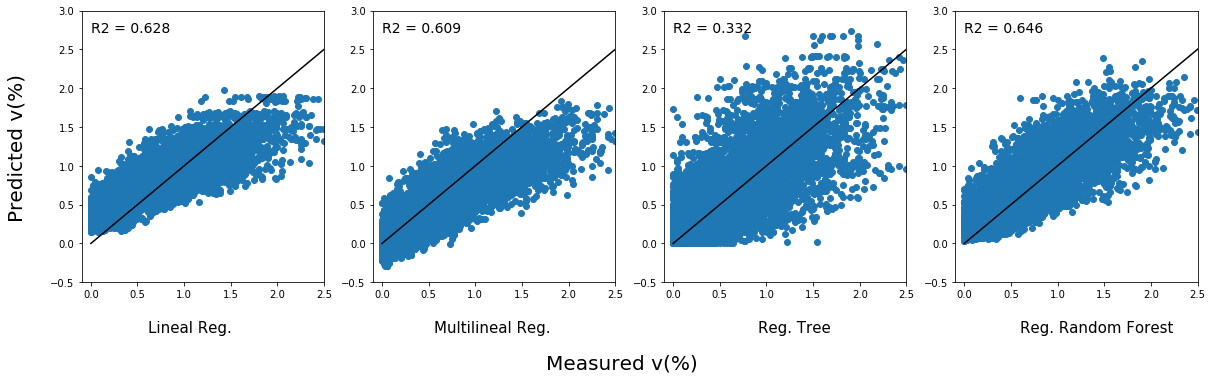

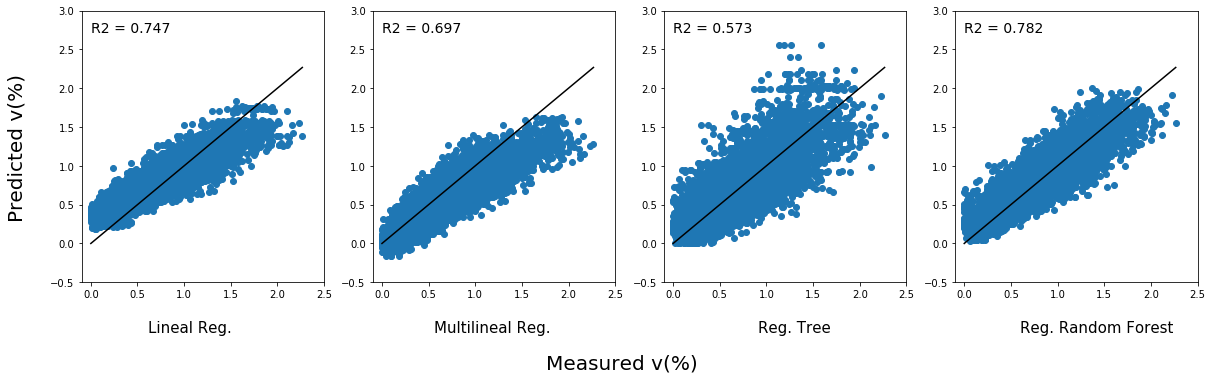

In [83]:
l_df_c4 = [df_c4_w3,df_c4_w5]
l_df_c5 = [df_c5_w3,df_c5_w5]
l_df_c6 = [df_c6_w3,df_c6_w5]
l_df_c7 = [df_c7_w3,df_c7_w5]

l_df_error = []
ut_vol_shape = c6_shape

l_df_error = []
viewers = []

#text params
init1=0
init2=2.75
spacing=0.035

for i,df in enumerate(l_df_c4):
    ## Datasets
    df_c457 = pd.concat([df,l_df_c5[i],l_df_c7[i]],ignore_index=True)

    df_train = shuffle(df_c457.copy())
    df_test = l_df_c6[i].copy()
    
    y_train = df_train['porosity'] # 'maximo_2', 'area2', 'att_12_prof', 'att_12','area3', 'maximo_3', 'middle_maximo', 'mean'
    X_train = df_train[['maximo_2', 'att_12_prof', 'att_12','maximo_3','middle_maximo']]
    # Multilineal regression needs of normalization
    X_train_sc = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_train),
                          columns=X_train.columns)
    
    X_test = df_test[['maximo_2', 'att_12_prof', 'att_12','maximo_3','middle_maximo']]
    X_test_sc = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_test),
                          columns=X_test.columns)
    y_test = df_test['porosity']
    
    ## Models
    # Linear only attenuation
    linr_att = skl.linear_model.LinearRegression()
    linr_scores_att = skl.model_selection.cross_validate(linr_att,
                                                         X_train['att_12_prof'].to_numpy().reshape((-1,1)),
                                                         y_train,
                                                         cv=5,
                                                         return_estimator=True)
 
    # MultiLineal
    linr = skl.linear_model.LinearRegression()
    linr_scores = skl.model_selection.cross_validate(linr,X_train_sc, y_train, cv=5, return_estimator=True)
#     print('Test scores on lineal of each fold (5)',linr_scores['test_score'])

    # Tree
    tree = sklearn.tree.DecisionTreeRegressor(criterion='mse')
    tree_scores = skl.model_selection.cross_validate(tree,X_train, y_train, cv=5, return_estimator=True)
#     print('Test scores on tree of each fold (5)',tree_scores['test_score'])

    # Random Forest
    n_estimators = 125
    max_feat = 0.8
    max_depth = 9
    max_samples = 0.5
    rf = skl.ensemble.RandomForestRegressor(n_estimators, max_features=max_feat)
    rf_scores  = skl.model_selection.cross_validate(rf,X_train, y_train, cv=5, return_estimator=True)
#     print('Test scores on Random forest of each fold (5)',rf_scores['test_score'],'\n')
    
    
    ## Predicting
    # random estimators from one of the folds used to predict, 1st fold selected: fold=0
    lineal_rand_est = linr_scores_att['estimator'][0]
    multilin_rand_est = linr_scores['estimator'][0]
    tree_rand_est = tree_scores['estimator'][0]
    rf_rand_est = rf_scores['estimator'][0]
    
    # Lineal only att.
    linr_att_porosity = lineal_rand_est.predict(X_test['att_12_prof'].to_numpy().reshape((-1,1)))
    linr_r2_att_porosity = skl.metrics.r2_score(y_test, linr_att_porosity)                                                     
    
    # MultiLineal
    multilinr_porosity = multilin_rand_est.predict(X_test_sc)
    multilinr_r2_porosity = skl.metrics.r2_score(y_test, multilinr_porosity)

    # Tree
    tree_porosity = tree_rand_est.predict(X_test)
    tree_r2_porosity = skl.metrics.r2_score(y_test, tree_porosity)

    # Random forest
    rf_porosity = rf_rand_est.predict(X_test)
    rf_r2_porosity = skl.metrics.r2_score(y_test, rf_porosity)
    l_R2 = [linr_r2_att_porosity,
            multilinr_r2_porosity,
            tree_r2_porosity,
            rf_r2_porosity]
                  
        
    ## ERROR ANALYSIS
    df_error = pd.DataFrame(X_test)
    df_error['porosity'] = y_test

    # Saving porosity predictions
    df_error['att_lineal_porosity'] = linr_att_porosity
    df_error['multilineal_porosity'] = multilinr_porosity
    df_error['tree_porosity'] = tree_porosity
    df_error['rf_porosity'] = rf_porosity

    # Computing error as a difference of "y" and pred_y and absolute error
    df_error['att_lineal_error'] = df_error['porosity'] - df_error['att_lineal_porosity']
    df_error['multilineal_error'] = df_error['porosity'] - df_error['multilineal_porosity']
    df_error['tree_error'] = df_error['porosity'] - df_error['tree_porosity']
    df_error['rf_error'] = df_error['porosity'] - df_error['rf_porosity']

    df_error['abs_lineal_error'] = np.abs(df_error['porosity'] - df_error['att_lineal_porosity'])
    df_error['abs_multilineal_error'] = np.abs(df_error['porosity'] - df_error['multilineal_porosity'])
    df_error['abs_tree_error'] = np.abs(df_error['porosity'] - df_error['tree_porosity'])
    df_error['abs_rf_error'] = np.abs(df_error['porosity'] - df_error['rf_porosity'])

    l_df_error.append(df_error)
    
    
    ## VISUALIZATION
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    
    # Lineal fit
    ax[0].scatter(y_test,linr_att_porosity)
    ax[1].scatter(y_test,multilinr_porosity)
    ax[2].scatter(y_test,tree_porosity)
    ax[3].scatter(y_test,rf_porosity)
    
    
    for i,eje in enumerate(ax):
        eje.plot([0,np.max(y_test)],[0,np.max(y_test)],'black')  
        eje.text(init1, init2-spacing,'R2 = {}'.format(np.round(l_R2[i], decimals=3))).set_fontsize(14)
        eje.set_xlim(xmin=-0.10, xmax=2.5)
        eje.set_ylim(ymin=-0.50, ymax=3)
    
    ## Texts
    # Axis titles
    fig.text(0.5, -0.10, 'Measured v(%)', ha='center', va='center').set_fontsize(20)
    fig.text(0.08, 0.5, 'Predicted v(%)', ha='center', va='center', rotation='vertical').set_fontsize(20)

#     fig.text(0.10, 0.82, 'Window 1', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.66, 'Window 3', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.50, 'Window 5', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.35, 'Window 7', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.19, 'Window 9', ha='center', va='center', rotation='vertical').set_fontsize(15)

    fig.text(0.20, 0, 'Lineal Reg.', ha='center', va='center').set_fontsize(15)
    fig.text(0.41, 0, 'Multilineal Reg.', ha='center', va='center').set_fontsize(15)
    fig.text(0.62, 0, 'Reg. Tree', ha='center', va='center').set_fontsize(15)
    fig.text(0.83, 0, 'Reg. Random Forest', ha='center', va='center').set_fontsize(15)
    plt.show()

l_feat_maps = []    
for df_vis in l_df_error:
    feat_maps = [] 
    for column in df_vis.iloc[:,:]:
        feat_maps.append( (column, df_vis[column].to_numpy().reshape(ut_vol_shape)) )
    l_feat_maps.append(feat_maps)
    viewers.append(plot_feat_maps(feat_maps))

### Attributes coefficients

### *Lineal*

In [84]:
print('Coeficient: ',np.round(lineal_rand_est.coef_[0],decimals=3), '\n','Intercept: ',np.round(lineal_rand_est.intercept_,decimals=3))

Coeficient:  0.077 
 Intercept:  -0.425


### *MultiLineal*

In [85]:
abs_linr_coefs = abs(multilin_rand_est.coef_)
linr_feats = X_train.columns
a_feat_imp = np.array([[feat,np.round(importance,decimals=3)] for importance, feat in sorted(zip(abs_linr_coefs,linr_feats) ,reverse=True)])
df_multilinr_feat_impor = pd.DataFrame({
            'feats (ordered)': a_feat_imp[:,0],
            'Multilineal Coefficients': a_feat_imp[:,1]}).set_index('feats (ordered)')
df_multilinr_feat_impor

,Multilineal Coefficients
feats (ordered),
att_12_prof,0.301
att_12,0.198
maximo_2,0.168
middle_maximo,0.091
maximo_3,0.065


### *Random Forest*

In [86]:
abs_rf_importances = rf_rand_est.feature_importances_


rf_feats = X_train.columns
a_feat_imp = np.array([[feat,np.round(importance,decimals=3)] for importance, feat in sorted(zip(abs_rf_importances,rf_feats) ,reverse=True)])
df_rf_feat_impor = pd.DataFrame({
            'feats (ordered)': a_feat_imp[:,0],
            'RF Coefficients': a_feat_imp[:,1]}).set_index('feats (ordered)')
df_rf_feat_impor

,RF Coefficients
feats (ordered),
att_12_prof,0.375
maximo_3,0.222
maximo_2,0.156
att_12,0.136
middle_maximo,0.111


In [87]:
pd.concat([df_multilinr_feat_impor,df_rf_feat_impor],axis=1)#.to_csv('c6_eval_coefficients.csv')

### Error statistics

### *Window 3*

In [88]:
l_df_error[0].iloc[:,10:].describe().round(decimals=2)#.to_csv('c6_w3_error_statistics.csv')

### *Window 5*

In [89]:
l_df_error[1].iloc[:,10:].describe().round(decimals=2)#.to_csv('c6_w5_error_statistics.csv')

### Error as feature maps

In [90]:
### Saving error Images
def save_imagen(array, pathlibpath,tipo,norm=False):
    if (norm == True):
        array = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(array))
        imagen = Image.fromarray(array)
    else:
        imagen = Image.fromarray(array.astype(tipo))
    imagen.save(pathlibpath) 

def save_feat_maps(feat_maps,pathlibpath,tipo='float'):
    for tupla in feat_maps:
        ruta = pathlibpath / (tupla[0]+'.tif')
        save_imagen(tupla[1],ruta,tipo)
    print('All feature maps saved')

In [91]:
## Concatenation of the error imgs for the dif. error
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
dif_err_concat = np.concatenate([viewers[0].layers['att_lineal_error'].data,
                            pad,     
                            viewers[0].layers['multilineal_error'].data,
                            pad,     
                            viewers[0].layers['tree_error'].data,
                            pad,     
                            viewers[0].layers['rf_error'].data],axis=1)

l_feat_maps[0].append( ('dif_err_concat',dif_err_concat) )
viewers[0].add_image(dif_err_concat,
                     contrast_limits=(l_df_error[1].iloc[:,10:].min().min(),l_df_error[1].iloc[:,10:].max().max()))

## Concat. of the abs. error imgs
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
abs_err_concat = np.concatenate([viewers[0].layers['abs_lineal_error'].data,
                            pad,     
                            viewers[0].layers['abs_multilineal_error'].data,
                            pad,     
                            viewers[0].layers['abs_tree_error'].data,
                            pad,     
                            viewers[0].layers['abs_rf_error'].data],axis=1)

l_feat_maps[0].append( ('abs_err_concat',abs_err_concat) )
viewers[0].add_image(abs_err_concat,
                     contrast_limits=(0,l_df_error[1].iloc[:,10:].max().max()))

<Image layer 'abs_err_concat' at 0x19b380e8fc8>

In [94]:
## Concatenation of the error imgs for the dif. error
ii = 1
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
dif_err_concat = np.concatenate([viewers[ii].layers['att_lineal_error'].data,
                            pad,     
                            viewers[ii].layers['multilineal_error'].data,
                            pad,     
                            viewers[ii].layers['tree_error'].data,
                            pad,     
                            viewers[ii].layers['rf_error'].data],axis=1)

l_feat_maps[ii].append( ('dif_err_concat',dif_err_concat) )
viewers[ii].add_image(dif_err_concat,
                     contrast_limits=(l_df_error[1].iloc[:,10:].min().min(),l_df_error[1].iloc[:,10:].max().max()))

## Concat. of the abs. error imgs
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
abs_err_concat = np.concatenate([viewers[ii].layers['abs_lineal_error'].data,
                            pad,     
                            viewers[ii].layers['abs_multilineal_error'].data,
                            pad,     
                            viewers[ii].layers['abs_tree_error'].data,
                            pad,     
                            viewers[ii].layers['abs_rf_error'].data],axis=1)

l_feat_maps[ii].append( ('abs_err_concat',abs_err_concat) )
viewers[ii].add_image(abs_err_concat,
                     contrast_limits=(0,l_df_error[1].iloc[:,10:].max().max()))

<Image layer 'abs_err_concat' at 0x19b56b2a5c8>

In [96]:
save_feat_maps(l_feat_maps[1],Path().cwd())

All feature maps saved


### *Training in c4,c5,c6; evaluation in c7*

### Dataset formation

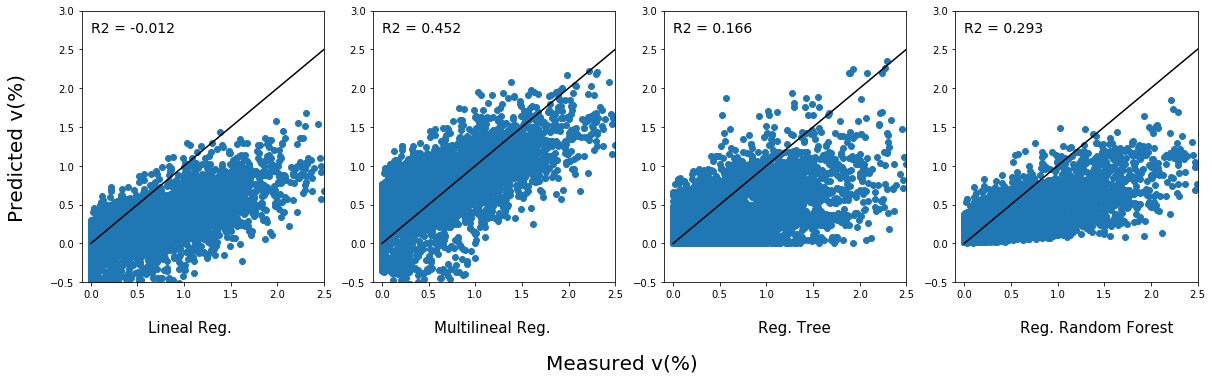

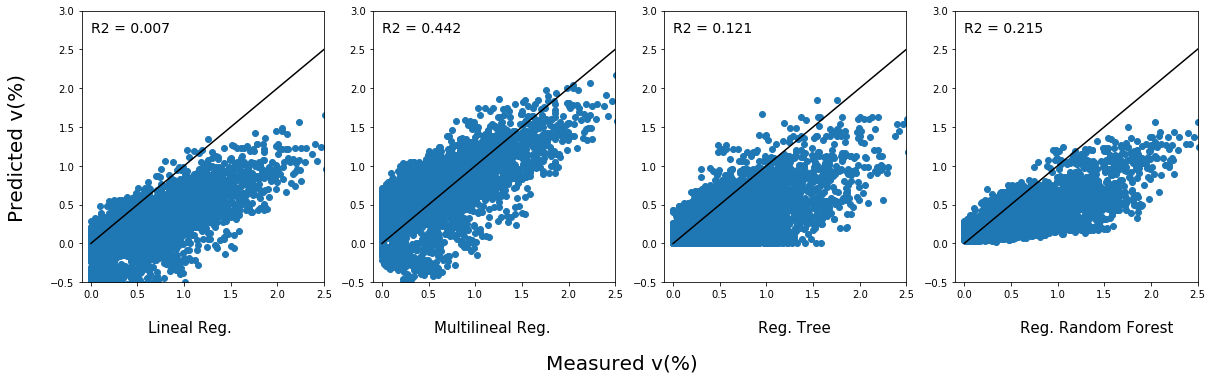

In [97]:
l_df_c4 = [df_c4_w3,df_c4_w5]
l_df_c5 = [df_c5_w3,df_c5_w5]
l_df_c6 = [df_c6_w3,df_c6_w5]
l_df_c7 = [df_c7_w3,df_c7_w5]

l_df_error = []
ut_vol_shape = c7_shape

l_df_error = []
viewers = []

#text params
init1=0
init2=2.75
spacing=0.035

for i,df in enumerate(l_df_c4):
    ## Datasets
    df_c456 = pd.concat([df,l_df_c5[i],l_df_c6[i]],ignore_index=True)

    df_train = shuffle(df_c456.copy())
    df_test = l_df_c7[i].copy()
    
    y_train = df_train['porosity'] # 'maximo_2', 'area2', 'att_12_prof', 'att_12','area3', 'maximo_3', 'middle_maximo', 'mean'
    X_train = df_train[['maximo_2', 'att_12_prof', 'att_12','maximo_3','middle_maximo']]
    # Multilineal regression needs of normalization
    X_train_sc = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_train),
                          columns=X_train.columns)
    
    X_test = df_test[['maximo_2', 'att_12_prof', 'att_12','maximo_3','middle_maximo']]
    X_test_sc = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X_test),
                          columns=X_test.columns)
    y_test = df_test['porosity']
    
    ## Models
    # Linear only attenuation
    linr_att = skl.linear_model.LinearRegression()
    linr_scores_att = skl.model_selection.cross_validate(linr_att,
                                                         X_train['att_12_prof'].to_numpy().reshape((-1,1)),
                                                         y_train,
                                                         cv=5,
                                                         return_estimator=True)
 
    # MultiLineal
    linr = skl.linear_model.LinearRegression()
    linr_scores = skl.model_selection.cross_validate(linr,X_train_sc, y_train, cv=5, return_estimator=True)
#     print('Test scores on lineal of each fold (5)',linr_scores['test_score'])

    # Tree
    tree = sklearn.tree.DecisionTreeRegressor(criterion='mse')
    tree_scores = skl.model_selection.cross_validate(tree,X_train, y_train, cv=5, return_estimator=True)
#     print('Test scores on tree of each fold (5)',tree_scores['test_score'])

    # Random Forest
    n_estimators = 140
    max_feat = 0.7
    max_depth = 9
    max_samples = 0.8
    rf = skl.ensemble.RandomForestRegressor(n_estimators, max_features=max_feat)
    rf_scores  = skl.model_selection.cross_validate(rf,X_train, y_train, cv=5, return_estimator=True)
#     print('Test scores on Random forest of each fold (5)',rf_scores['test_score'],'\n')
    
    
    ## Predicting
    # random estimators from one of the folds used to predict, 1st fold selected: fold=0
    lineal_rand_est = linr_scores_att['estimator'][0]
    multilin_rand_est = linr_scores['estimator'][0]
    tree_rand_est = tree_scores['estimator'][0]
    rf_rand_est = rf_scores['estimator'][0]
    
    # Lineal only att.
    linr_att_porosity = lineal_rand_est.predict(X_test['att_12_prof'].to_numpy().reshape((-1,1)))
    linr_r2_att_porosity = skl.metrics.r2_score(y_test, linr_att_porosity)                                                     
    
    # MultiLineal
    multilinr_porosity = multilin_rand_est.predict(X_test_sc)
    multilinr_r2_porosity = skl.metrics.r2_score(y_test, multilinr_porosity)

    # Tree
    tree_porosity = tree_rand_est.predict(X_test)
    tree_r2_porosity = skl.metrics.r2_score(y_test, tree_porosity)

    # Random forest
    rf_porosity = rf_rand_est.predict(X_test)
    rf_r2_porosity = skl.metrics.r2_score(y_test, rf_porosity)
    l_R2 = [linr_r2_att_porosity,
            multilinr_r2_porosity,
            tree_r2_porosity,
            rf_r2_porosity]
                  
        
    ## ERROR ANALYSIS
    df_error = pd.DataFrame(X_test)
    df_error['porosity'] = y_test

    # Saving porosity predictions
    df_error['att_lineal_porosity'] = linr_att_porosity
    df_error['multilineal_porosity'] = multilinr_porosity
    df_error['tree_porosity'] = tree_porosity
    df_error['rf_porosity'] = rf_porosity

    # Computing error as a difference of "y" and pred_y and absolute error
    df_error['att_lineal_error'] = df_error['porosity'] - df_error['att_lineal_porosity']
    df_error['multilineal_error'] = df_error['porosity'] - df_error['multilineal_porosity']
    df_error['tree_error'] = df_error['porosity'] - df_error['tree_porosity']
    df_error['rf_error'] = df_error['porosity'] - df_error['rf_porosity']

    df_error['abs_lineal_error'] = np.abs(df_error['porosity'] - df_error['att_lineal_porosity'])
    df_error['abs_multilineal_error'] = np.abs(df_error['porosity'] - df_error['multilineal_porosity'])
    df_error['abs_tree_error'] = np.abs(df_error['porosity'] - df_error['tree_porosity'])
    df_error['abs_rf_error'] = np.abs(df_error['porosity'] - df_error['rf_porosity'])

    l_df_error.append(df_error)
    
    
    ## VISUALIZATION
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    
    # Lineal fit
    ax[0].scatter(y_test,linr_att_porosity)
    ax[1].scatter(y_test,multilinr_porosity)
    ax[2].scatter(y_test,tree_porosity)
    ax[3].scatter(y_test,rf_porosity)
    
    
    for i,eje in enumerate(ax):
        eje.plot([0,np.max(y_test)],[0,np.max(y_test)],'black')  
        eje.text(init1, init2-spacing,'R2 = {}'.format(np.round(l_R2[i], decimals=3))).set_fontsize(14)
        eje.set_xlim(xmin=-0.10, xmax=2.5)
        eje.set_ylim(ymin=-0.50, ymax=3)
    
    ## Texts
    # Axis titles
    fig.text(0.5, -0.10, 'Measured v(%)', ha='center', va='center').set_fontsize(20)
    fig.text(0.08, 0.5, 'Predicted v(%)', ha='center', va='center', rotation='vertical').set_fontsize(20)

#     fig.text(0.10, 0.82, 'Window 1', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.66, 'Window 3', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.50, 'Window 5', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.35, 'Window 7', ha='center', va='center', rotation='vertical').set_fontsize(15)
#     fig.text(0.10, 0.19, 'Window 9', ha='center', va='center', rotation='vertical').set_fontsize(15)

    fig.text(0.20, 0, 'Lineal Reg.', ha='center', va='center').set_fontsize(15)
    fig.text(0.41, 0, 'Multilineal Reg.', ha='center', va='center').set_fontsize(15)
    fig.text(0.62, 0, 'Reg. Tree', ha='center', va='center').set_fontsize(15)
    fig.text(0.83, 0, 'Reg. Random Forest', ha='center', va='center').set_fontsize(15)
    plt.show()

l_feat_maps = []    
for df_vis in l_df_error:
    feat_maps = [] 
    for column in df_vis.iloc[:,:]:
        feat_maps.append( (column, df_vis[column].to_numpy().reshape(ut_vol_shape)) )
    l_feat_maps.append(feat_maps)
    viewers.append(plot_feat_maps(feat_maps))

### Attributes coefficients

### *Lineal*

In [98]:
print('Coeficient: ',np.round(lineal_rand_est.coef_[0],decimals=3), '\n','Intercept: ',np.round(lineal_rand_est.intercept_,decimals=3))

Coeficient:  0.094 
 Intercept:  -0.755


### *MultiLineal*

In [99]:
abs_linr_coefs = abs(multilin_rand_est.coef_)
linr_feats = X_train.columns
a_feat_imp = np.array([[feat,np.round(importance,decimals=3)] for importance, feat in sorted(zip(abs_linr_coefs,linr_feats) ,reverse=True)])
df_multilinr_feat_impor = pd.DataFrame({
            'feats (ordered)': a_feat_imp[:,0],
            'Multilineal Coefficients': a_feat_imp[:,1]}).set_index('feats (ordered)')
df_multilinr_feat_impor

,Multilineal Coefficients
feats (ordered),
att_12_prof,0.211
att_12,0.146
maximo_3,0.047
maximo_2,0.031
middle_maximo,0.008


### *Random Forest*

In [100]:
abs_rf_importances = rf_rand_est.feature_importances_


rf_feats = X_train.columns
a_feat_imp = np.array([[feat,np.round(importance,decimals=3)] for importance, feat in sorted(zip(abs_rf_importances,rf_feats) ,reverse=True)])
df_rf_feat_impor = pd.DataFrame({
            'feats (ordered)': a_feat_imp[:,0],
            'RF Coefficients': a_feat_imp[:,1]}).set_index('feats (ordered)')
df_rf_feat_impor

,RF Coefficients
feats (ordered),
att_12_prof,0.457
att_12,0.334
maximo_3,0.085
maximo_2,0.074
middle_maximo,0.05


In [101]:
pd.concat([df_multilinr_feat_impor,df_rf_feat_impor],axis=1)#.to_csv('c7_eval_coefficients.csv')

### Error statistics

### *Window 3*

In [102]:
l_df_error[0].iloc[:,10:].describe().round(decimals=2)#.to_csv('c7_w3_error_statistics.csv')

### *Window 5*

In [103]:
l_df_error[1].iloc[:,10:].describe().round(decimals=2)#.to_csv('c7_w5_error_statistics.csv')

### Error as feature maps

In [90]:
### Saving error Images
def save_imagen(array, pathlibpath,tipo,norm=False):
    if (norm == True):
        array = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(array))
        imagen = Image.fromarray(array)
    else:
        imagen = Image.fromarray(array.astype(tipo))
    imagen.save(pathlibpath) 

def save_feat_maps(feat_maps,pathlibpath,tipo='float'):
    for tupla in feat_maps:
        ruta = pathlibpath / (tupla[0]+'.tif')
        save_imagen(tupla[1],ruta,tipo)
    print('All feature maps saved')

In [104]:
## Concatenation of the error imgs for the dif. error
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
dif_err_concat = np.concatenate([viewers[0].layers['att_lineal_error'].data,
                            pad,     
                            viewers[0].layers['multilineal_error'].data,
                            pad,     
                            viewers[0].layers['tree_error'].data,
                            pad,     
                            viewers[0].layers['rf_error'].data],axis=1)

l_feat_maps[0].append( ('dif_err_concat',dif_err_concat) )
viewers[0].add_image(dif_err_concat,
                     contrast_limits=(l_df_error[1].iloc[:,10:].min().min(),l_df_error[1].iloc[:,10:].max().max()))

## Concat. of the abs. error imgs
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
abs_err_concat = np.concatenate([viewers[0].layers['abs_lineal_error'].data,
                            pad,     
                            viewers[0].layers['abs_multilineal_error'].data,
                            pad,     
                            viewers[0].layers['abs_tree_error'].data,
                            pad,     
                            viewers[0].layers['abs_rf_error'].data],axis=1)

l_feat_maps[0].append( ('abs_err_concat',abs_err_concat) )
viewers[0].add_image(abs_err_concat,
                     contrast_limits=(0,l_df_error[1].iloc[:,10:].max().max()))

<Image layer 'abs_err_concat' at 0x19b1084dc88>

In [105]:
## Concatenation of the error imgs for the dif. error
ii = 1
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
dif_err_concat = np.concatenate([viewers[ii].layers['att_lineal_error'].data,
                            pad,     
                            viewers[ii].layers['multilineal_error'].data,
                            pad,     
                            viewers[ii].layers['tree_error'].data,
                            pad,     
                            viewers[ii].layers['rf_error'].data],axis=1)

l_feat_maps[ii].append( ('dif_err_concat',dif_err_concat) )
viewers[ii].add_image(dif_err_concat,
                     contrast_limits=(l_df_error[1].iloc[:,10:].min().min(),l_df_error[1].iloc[:,10:].max().max()))

## Concat. of the abs. error imgs
pad = -10* np.ones((ut_vol_shape[0],5),dtype=int)
abs_err_concat = np.concatenate([viewers[ii].layers['abs_lineal_error'].data,
                                 
                            pad,     
                            viewers[ii].layers['abs_multilineal_error'].data,
                            pad,     
                            viewers[ii].layers['abs_tree_error'].data,
                            pad,     
                            viewers[ii].layers['abs_rf_error'].data],axis=1)

l_feat_maps[ii].append( ('abs_err_concat',abs_err_concat) )
viewers[ii].add_image(abs_err_concat,
                     contrast_limits=(0,l_df_error[1].iloc[:,10:].max().max()))

<Image layer 'abs_err_concat' at 0x19b11723ec8>

In [107]:
save_feat_maps(l_feat_maps[1],Path().cwd())

All feature maps saved
